# Импортируем нужные библиотеки

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, metrics, tree, ensemble
import lightgbm as lgb

import numpy as np
import pandas as pd
import seaborn as sns

import time

# Готовим данные

Генерируем с помощью sklearn.datasets.make_classification (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) со следующими параметрами:
1. Наблюдений - 10 тысяч
2. Всех фичей - 100
3. Неслучайных фичей - 50
4. Число линейно зависимых фичей - 0
5. Классов - 3
6. Кластеров для каждого класса - 2
7. Информативные фичи идут первыми по порядку

In [ ]:
classification_problem = datasets.make_classification(n_samples=10000, n_features=100, n_classes=3,
                                                      n_informative=50, n_redundant=0,
                                                      n_clusters_per_class=2,
                                                      shuffle=False, random_state=42)

Цвета для отрисовки принадлежности к классам:
- 0 - красный
- 1 - синий
- 2 - зелёный

In [ ]:
colors = ListedColormap(['#EE0000', '#0000EE', '#00E000'])
light_colors = ListedColormap(['#FFB6C1', '#6495ED', '#E5FFCC'])

Разбиваем выборку на **train** и **test** в отношении 7:3

In [ ]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_problem[0],
                                                                                    classification_problem[1],
                                                                                    test_size=0.3,
                                                                                    random_state=42)

Вспомогательная функция для обучения моделей и замера качества на **train**/**test**

In [ ]:
def fit_and_metrics(estimator, train_data, train_labels, test_data, test_labels):
    start_time = time.time()
    estimator.fit(train_data, train_labels)
    print(f'Learning time = {round(time.time() - start_time, 3)} s')

    predictions = estimator.predict(train_data)
    print(f'Train: {round(metrics.accuracy_score(train_labels, predictions), 5)}')

    predictions = estimator.predict(test_data)
    print(f'Test: {round(metrics.accuracy_score(test_labels, predictions), 5)}')

    return estimator

# Обучение моделей

## Дерево решений

Подробнее - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier

In [ ]:
train_labels

array([2, 1, 1, ..., 0, 0, 1])

In [ ]:
tree_clf = fit_and_metrics(tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=1700, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 0.139 s
Train: 0.43014
Test: 0.43433


Моделируем дерево

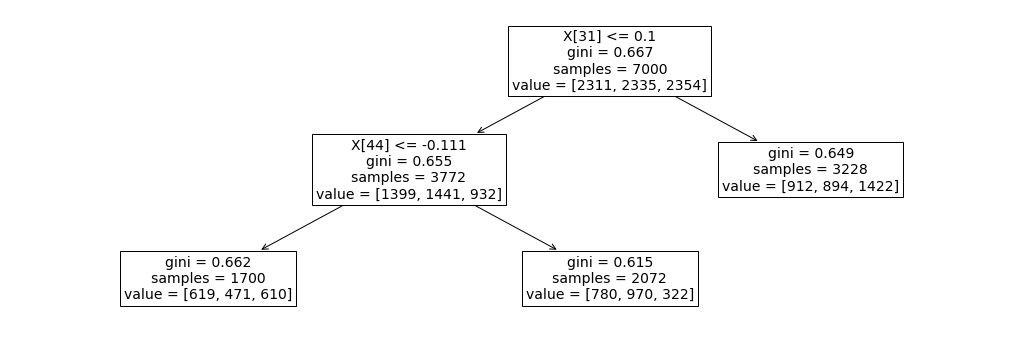

In [ ]:
plt.figure(figsize = (18, 6))
txt = tree.plot_tree(tree_clf, fontsize=14)

Функции для отрисовки результатов работы дерева

In [ ]:
def get_meshgrid(data, i=0, j=1):
    x_min, x_max = data[:, i].min() - 1, data[:, i].max() + 1
    y_min, y_max = data[:, j].min() - 1, data[:, j].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.1),
                       np.arange(y_min, y_max, 0.1))

In [ ]:
def plot_decision_surface(estimator, data, labels, i, j, colors=colors, light_colors=light_colors):

    plt.figure(figsize=(8, 8))

    xx, yy = get_meshgrid(data, 31, 44)

    data_ext = np.zeros((xx.ravel().shape[0], 100))
    data_ext[:, i] = xx.ravel()
    data_ext[:, j] = yy.ravel()

    mesh_predictions = np.array(estimator.predict(data_ext)).reshape(xx.shape)

    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(data[:, 31], data[:, 44], c=labels, s=10, cmap=colors)
    plt.xlabel(f'X[{i}]')
    plt.ylabel(f'X[{j}]')
    plt.show()

Работа дерева на плоскости

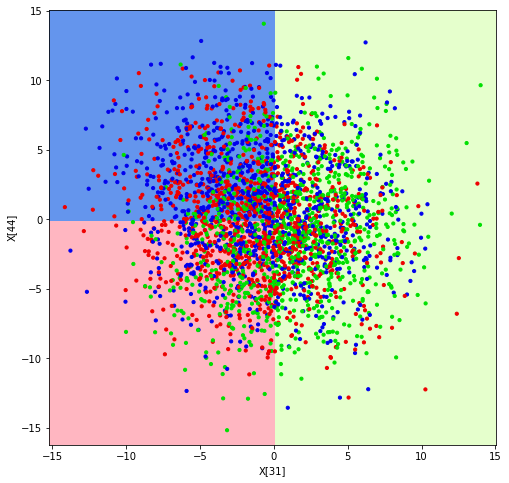

In [ ]:
plot_decision_surface(tree_clf, test_data, test_labels, 31, 44, colors=colors, light_colors=light_colors)

## Случайный лес

Подробнее - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier

In [ ]:
forest_clf = fit_and_metrics(ensemble.RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_leaf=1000,
                                                             max_features='sqrt', random_state=42),
                             train_data, train_labels, test_data, test_labels)

Learning time = 0.094 s
Train: 0.53657
Test: 0.524


Качество усредняемых моделей

In [ ]:
accuracy_trees = {}
for i, estimator in enumerate(forest_clf.estimators_):
    accuracy_trees[i] = round(estimator.score(test_data, test_labels), 3)

In [ ]:
top = sorted(accuracy_trees, key=accuracy_trees.get)
print(f'min. Tree: {top[0]}. Accuracy: {accuracy_trees[top[0]]}')
print(f'max. Tree: {top[-1]}. Accuracy: {accuracy_trees[top[-1]]}')

min. Tree: 4. Accuracy: 0.396
max. Tree: 0. Accuracy: 0.454


Самое сильное дерево

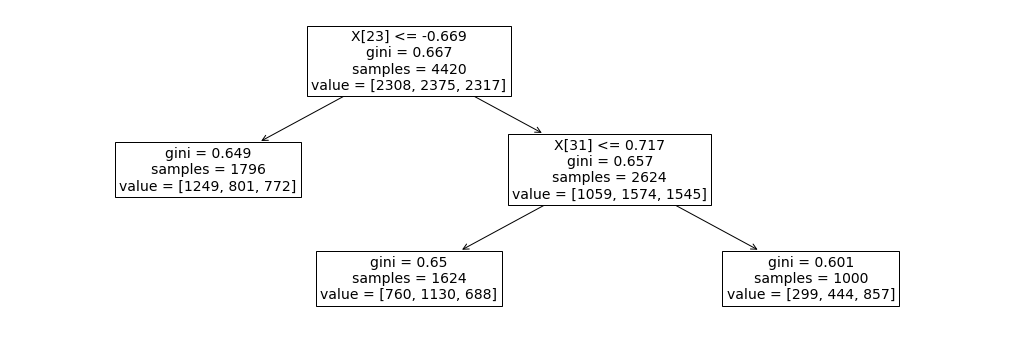

In [ ]:
plt.figure(figsize = (18, 6))
txt = tree.plot_tree(forest_clf.estimators_[0], fontsize=14)

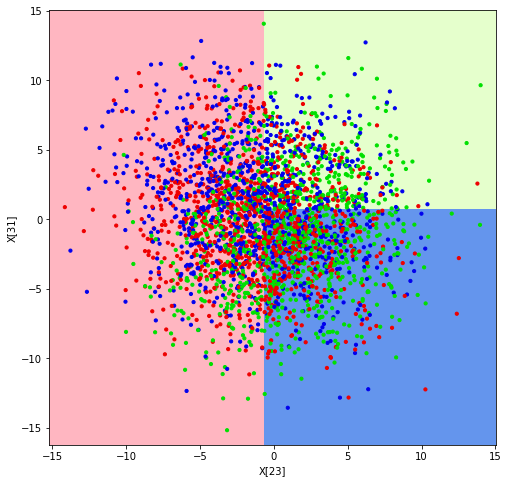

In [ ]:
plot_decision_surface(forest_clf.estimators_[0], test_data, test_labels, 23, 31, colors=colors, light_colors=light_colors)

Топ-15 фичей решающего дерева

In [ ]:
feats = {}
for feature, importance in enumerate(forest_clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(15)

,Features,Gini-Importance
0,23,0.178404
1,31,0.158313
2,2,0.091571
3,44,0.077080
4,39,0.070083
5,49,0.067639
6,48,0.064453
7,14,0.052728
8,29,0.042685
9,46,0.035547


## Градиентный бустинг LGBM

Подробнее - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

Для получения не переобученной модели с высоким качеством достаточно настройки следующих **гиперпараметров**:
1. **n_estimators** - число деревьев
2. **max_depth** - максимальная глубина деревьев
3. **learning_rate** - "длина" шага алгоритма (множитель перед предсказанием каждого дерева)

In [ ]:
lgbm_clf = fit_and_metrics(lgb.LGBMClassifier(n_estimators=10, max_depth=3, learning_rate=0.9, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 0.144 s
Train: 0.81557
Test: 0.735


Про визуализацию деревьев градиентного бустинга - https://russianblogs.com/article/5797349374/.

Топ-15 фичей градиентного бустинга

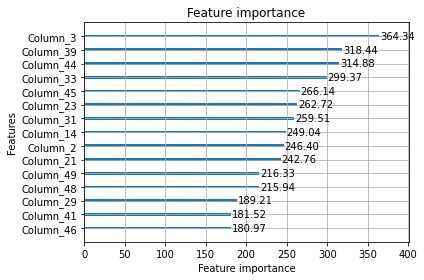

In [ ]:
lgb.plot_importance(lgbm_clf, importance_type='gain', max_num_features=15, precision=2)
plt.tight_layout()
plt.show()

## Сравнение зависимости качества случайного леса и градиентного бустинга от числа деревьев

In [ ]:
def plot_train_test_metrics(model_nm, train_list, test_list, n_max):
    plt.figure(figsize=(8,6))
    plt.title(model_nm)
    plt.plot(range(1, n_max + 1, 3), train_list, label='Train')
    plt.plot(range(1, n_max + 1, 3), test_list, label='Test')
    plt.xlabel('Число деревьев')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

~~~ n_estimators = 1 ~~~
RandomForestClassifier:
Learning time = 0.024 s
Train: 0.46986
Test: 0.44767
LGBMClassifier:
Learning time = 0.063 s
Train: 0.46043
Test: 0.46533
~~~ n_estimators = 4 ~~~
RandomForestClassifier:
Learning time = 0.12 s
Train: 0.60771
Test: 0.555
LGBMClassifier:
Learning time = 0.069 s
Train: 0.55257
Test: 0.53567
~~~ n_estimators = 7 ~~~
RandomForestClassifier:
Learning time = 0.173 s
Train: 0.64771
Test: 0.59667
LGBMClassifier:
Learning time = 0.051 s
Train: 0.60243
Test: 0.57267
~~~ n_estimators = 10 ~~~
RandomForestClassifier:
Learning time = 0.238 s
Train: 0.67386
Test: 0.62467
LGBMClassifier:
Learning time = 0.054 s
Train: 0.62343
Test: 0.59933
~~~ n_estimators = 13 ~~~
RandomForestClassifier:
Learning time = 0.285 s
Train: 0.69886
Test: 0.64867
LGBMClassifier:
Learning time = 0.061 s
Train: 0.65443
Test: 0.62567
~~~ n_estimators = 16 ~~~
RandomForestClassifier:
Learning time = 0.333 s
Train: 0.71371
Test: 0.674
LGBMClassifier:
Learning time = 0.059 s
Train

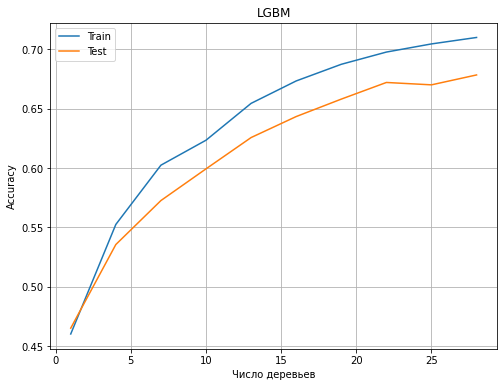

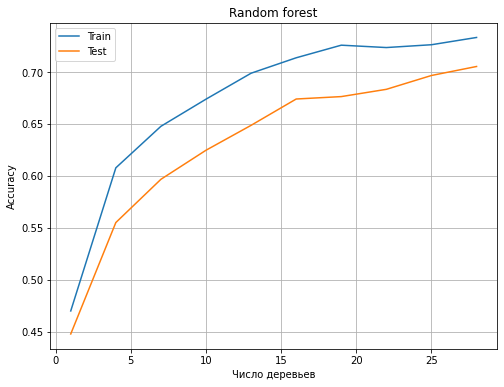

~~~ n_estimators = 31 ~~~
RandomForestClassifier:
Learning time = 0.543 s
Train: 0.73143
Test: 0.69667
LGBMClassifier:
Learning time = 0.07 s
Train: 0.71543
Test: 0.69233
~~~ n_estimators = 34 ~~~
RandomForestClassifier:
Learning time = 0.63 s
Train: 0.73943
Test: 0.69933
LGBMClassifier:
Learning time = 0.072 s
Train: 0.72329
Test: 0.685
~~~ n_estimators = 37 ~~~
RandomForestClassifier:
Learning time = 0.692 s
Train: 0.74671
Test: 0.70233
LGBMClassifier:
Learning time = 0.073 s
Train: 0.72814
Test: 0.69033
~~~ n_estimators = 40 ~~~
RandomForestClassifier:
Learning time = 0.778 s
Train: 0.75014
Test: 0.702
LGBMClassifier:
Learning time = 0.075 s
Train: 0.734
Test: 0.69667
~~~ n_estimators = 43 ~~~
RandomForestClassifier:
Learning time = 0.794 s
Train: 0.75614
Test: 0.70867
LGBMClassifier:
Learning time = 0.079 s
Train: 0.73629
Test: 0.702
~~~ n_estimators = 46 ~~~
RandomForestClassifier:
Learning time = 0.837 s
Train: 0.75286
Test: 0.71367
LGBMClassifier:
Learning time = 0.078 s
Train: 

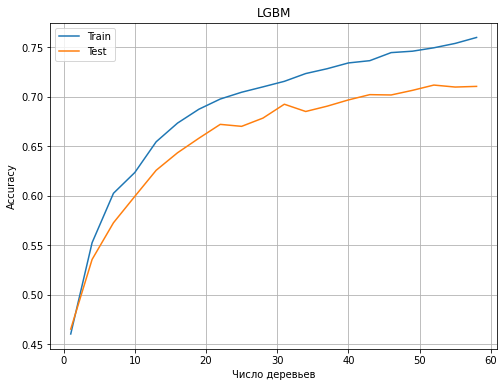

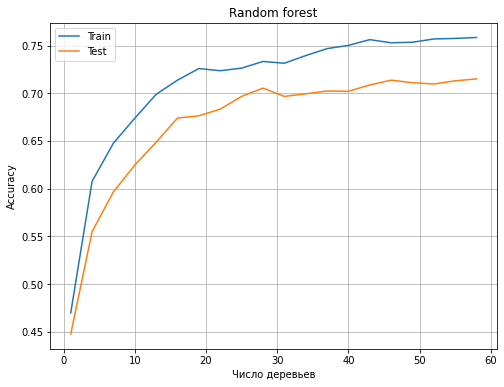

~~~ n_estimators = 61 ~~~
RandomForestClassifier:
Learning time = 0.998 s
Train: 0.76114
Test: 0.713
LGBMClassifier:
Learning time = 0.095 s
Train: 0.75886
Test: 0.707
~~~ n_estimators = 64 ~~~
RandomForestClassifier:
Learning time = 1.178 s
Train: 0.75829
Test: 0.71167
LGBMClassifier:
Learning time = 0.105 s
Train: 0.76143
Test: 0.70633
~~~ n_estimators = 67 ~~~
RandomForestClassifier:
Learning time = 1.19 s
Train: 0.75929
Test: 0.70833
LGBMClassifier:
Learning time = 0.096 s
Train: 0.76214
Test: 0.70067
~~~ n_estimators = 70 ~~~
RandomForestClassifier:
Learning time = 1.268 s
Train: 0.76157
Test: 0.71467
LGBMClassifier:
Learning time = 0.094 s
Train: 0.76757
Test: 0.70433
~~~ n_estimators = 73 ~~~
RandomForestClassifier:
Learning time = 1.357 s
Train: 0.764
Test: 0.71567
LGBMClassifier:
Learning time = 0.11 s
Train: 0.77071
Test: 0.705
~~~ n_estimators = 76 ~~~
RandomForestClassifier:
Learning time = 1.387 s
Train: 0.768
Test: 0.71767
LGBMClassifier:
Learning time = 0.125 s
Train: 0.

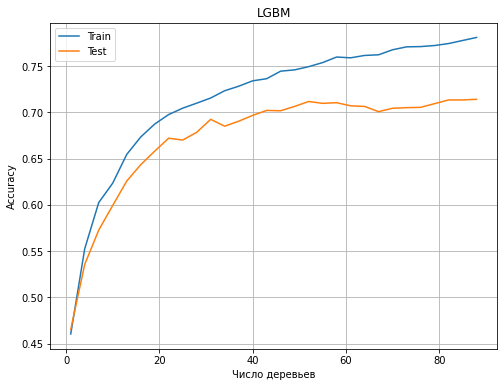

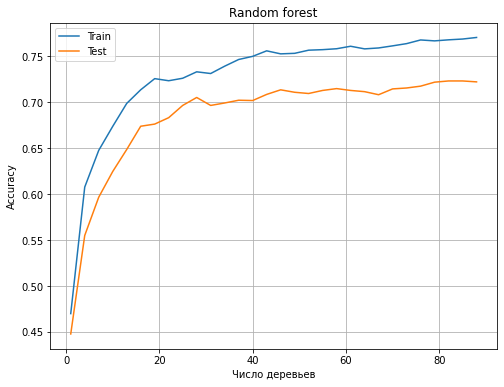

~~~ n_estimators = 91 ~~~
RandomForestClassifier:
Learning time = 1.508 s
Train: 0.77
Test: 0.72233
LGBMClassifier:
Learning time = 0.111 s
Train: 0.78143
Test: 0.717
~~~ n_estimators = 94 ~~~
RandomForestClassifier:
Learning time = 1.616 s
Train: 0.76929
Test: 0.722
LGBMClassifier:
Learning time = 0.128 s
Train: 0.783
Test: 0.71
~~~ n_estimators = 97 ~~~
RandomForestClassifier:
Learning time = 1.75 s
Train: 0.77029
Test: 0.725
LGBMClassifier:
Learning time = 0.134 s
Train: 0.782
Test: 0.71167
~~~ n_estimators = 100 ~~~
RandomForestClassifier:
Learning time = 1.722 s
Train: 0.77171
Test: 0.726
LGBMClassifier:
Learning time = 0.144 s
Train: 0.78543
Test: 0.71167
~~~ n_estimators = 103 ~~~
RandomForestClassifier:
Learning time = 1.733 s
Train: 0.76871
Test: 0.72667
LGBMClassifier:
Learning time = 0.14 s
Train: 0.78529
Test: 0.70867
~~~ n_estimators = 106 ~~~
RandomForestClassifier:
Learning time = 1.837 s
Train: 0.76871
Test: 0.72667
LGBMClassifier:
Learning time = 0.14 s
Train: 0.78671


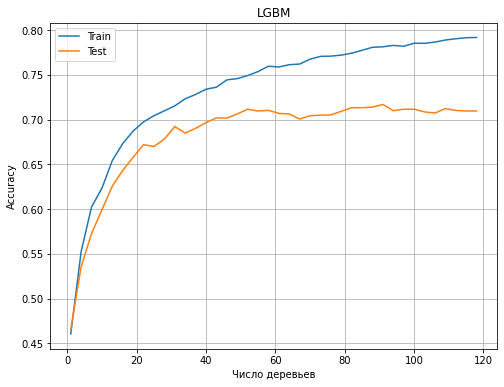

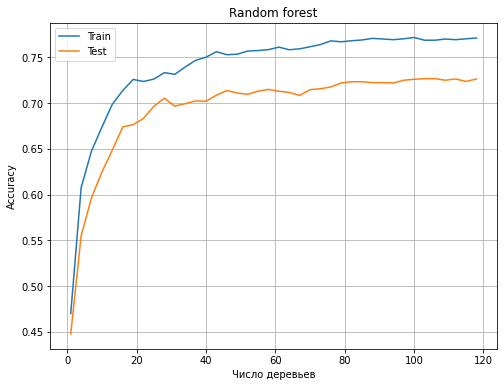

~~~ n_estimators = 121 ~~~
RandomForestClassifier:
Learning time = 2.004 s
Train: 0.77057
Test: 0.72767
LGBMClassifier:
Learning time = 0.141 s
Train: 0.79286
Test: 0.713
~~~ n_estimators = 124 ~~~
RandomForestClassifier:
Learning time = 2.109 s
Train: 0.77029
Test: 0.729
LGBMClassifier:
Learning time = 0.172 s
Train: 0.79329
Test: 0.713
~~~ n_estimators = 127 ~~~
RandomForestClassifier:
Learning time = 2.141 s
Train: 0.77157
Test: 0.72767
LGBMClassifier:
Learning time = 0.16 s
Train: 0.79429
Test: 0.71533
~~~ n_estimators = 130 ~~~
RandomForestClassifier:
Learning time = 2.268 s
Train: 0.77157
Test: 0.726
LGBMClassifier:
Learning time = 0.178 s
Train: 0.79629
Test: 0.71333
~~~ n_estimators = 133 ~~~
RandomForestClassifier:
Learning time = 2.317 s
Train: 0.77257
Test: 0.72567
LGBMClassifier:
Learning time = 0.151 s
Train: 0.79757
Test: 0.717
~~~ n_estimators = 136 ~~~
RandomForestClassifier:
Learning time = 2.33 s
Train: 0.77414
Test: 0.726
LGBMClassifier:
Learning time = 0.157 s
Train

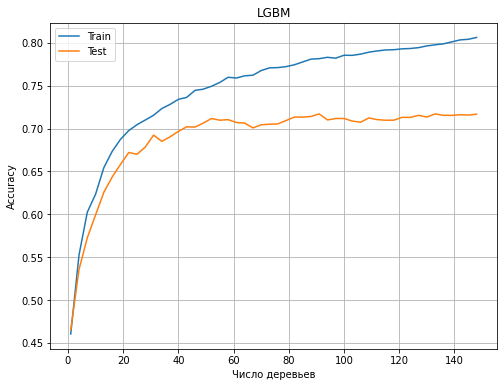

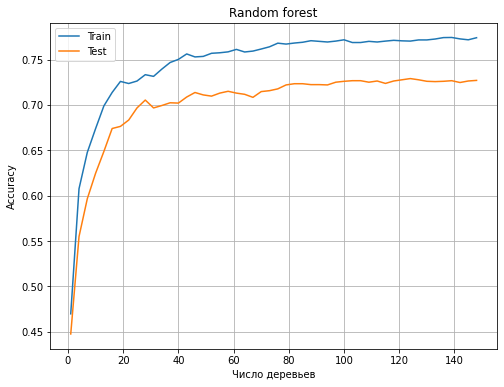

~~~ n_estimators = 151 ~~~
RandomForestClassifier:
Learning time = 2.47 s
Train: 0.77357
Test: 0.72767
LGBMClassifier:
Learning time = 0.138 s
Train: 0.80657
Test: 0.71533
~~~ n_estimators = 154 ~~~
RandomForestClassifier:
Learning time = 2.564 s
Train: 0.77429
Test: 0.72967
LGBMClassifier:
Learning time = 0.161 s
Train: 0.80771
Test: 0.715
~~~ n_estimators = 157 ~~~
RandomForestClassifier:
Learning time = 2.672 s
Train: 0.77386
Test: 0.72933
LGBMClassifier:
Learning time = 0.19 s
Train: 0.80829
Test: 0.71567
~~~ n_estimators = 160 ~~~
RandomForestClassifier:
Learning time = 2.672 s
Train: 0.77486
Test: 0.73
LGBMClassifier:
Learning time = 0.155 s
Train: 0.80886
Test: 0.71433
~~~ n_estimators = 163 ~~~
RandomForestClassifier:
Learning time = 2.703 s
Train: 0.77414
Test: 0.73
LGBMClassifier:
Learning time = 0.158 s
Train: 0.81129
Test: 0.71633
~~~ n_estimators = 166 ~~~
RandomForestClassifier:
Learning time = 2.798 s
Train: 0.77486
Test: 0.728
LGBMClassifier:
Learning time = 0.161 s
Tra

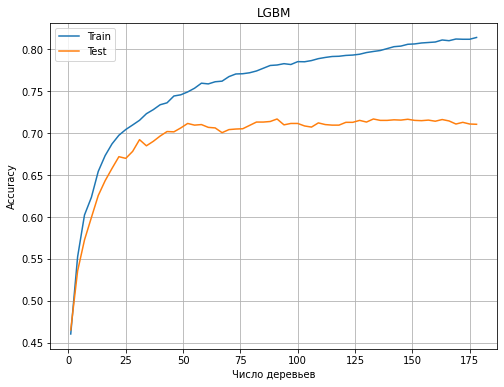

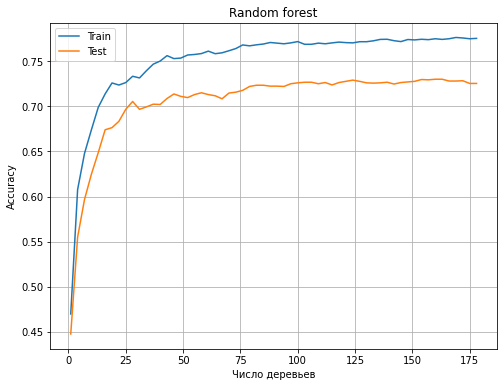

~~~ n_estimators = 181 ~~~
RandomForestClassifier:
Learning time = 2.95 s
Train: 0.77543
Test: 0.72467
LGBMClassifier:
Learning time = 0.173 s
Train: 0.816
Test: 0.71133
~~~ n_estimators = 184 ~~~
RandomForestClassifier:
Learning time = 3.076 s
Train: 0.77657
Test: 0.72567
LGBMClassifier:
Learning time = 0.183 s
Train: 0.81714
Test: 0.70933
~~~ n_estimators = 187 ~~~
RandomForestClassifier:
Learning time = 3.195 s
Train: 0.77557
Test: 0.725
LGBMClassifier:
Learning time = 0.181 s
Train: 0.81857
Test: 0.70867
~~~ n_estimators = 190 ~~~
RandomForestClassifier:
Learning time = 3.287 s
Train: 0.77457
Test: 0.72533
LGBMClassifier:
Learning time = 0.226 s
Train: 0.81871
Test: 0.71067
~~~ n_estimators = 193 ~~~
RandomForestClassifier:
Learning time = 3.364 s
Train: 0.77457
Test: 0.72567
LGBMClassifier:
Learning time = 0.178 s
Train: 0.818
Test: 0.71067
~~~ n_estimators = 196 ~~~
RandomForestClassifier:
Learning time = 3.265 s
Train: 0.77557
Test: 0.726
LGBMClassifier:
Learning time = 0.186 s


In [ ]:
forest_train_accuracy = []
forest_test_accuracy = []
lgbm_train_accuracy = []
lgbm_test_accuracy = []

for n in range(1, 202, 3):
    print(f'~~~ n_estimators = {n} ~~~')
    print('RandomForestClassifier:')
    estimator = fit_and_metrics(ensemble.RandomForestClassifier(n_estimators=n, max_depth=4,
                                                                max_features='sqrt', bootstrap=True,
                                                                random_state=42),
                                train_data, train_labels, test_data, test_labels)
    forest_train_accuracy.append(estimator.score(train_data, train_labels))
    forest_test_accuracy.append(estimator.score(test_data, test_labels))

    print('LGBMClassifier:')
    estimator = fit_and_metrics(lgb.LGBMClassifier(n_estimators=n, max_depth=1, learning_rate=1.0,
                                                   subsample=0.01, colsample_bytree=0.5,
                                                   random_state=42),
                                train_data, train_labels, test_data, test_labels)
    lgbm_train_accuracy.append(estimator.score(train_data, train_labels))
    lgbm_test_accuracy.append(estimator.score(test_data, test_labels))

    if (n + 2) % 30 == 0:
        plot_train_test_metrics('LGBM', lgbm_train_accuracy, lgbm_test_accuracy, n)
        plot_train_test_metrics('Random forest', forest_train_accuracy, forest_test_accuracy, n)

Градиентный бустинг может переобучаться при увеличении числа деревьев. Случайный лес - нет

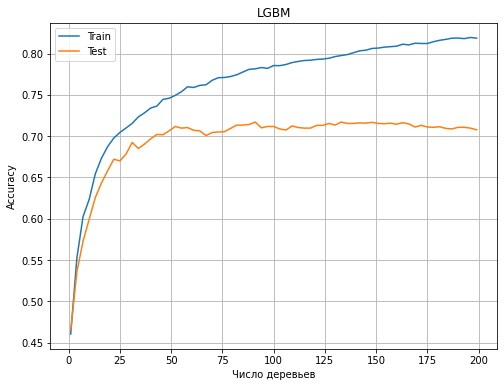

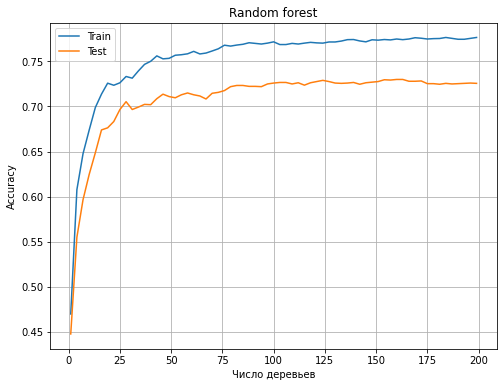

In [ ]:
plot_train_test_metrics('LGBM', lgbm_train_accuracy, lgbm_test_accuracy, 201)
plot_train_test_metrics('Random forest', forest_train_accuracy, forest_test_accuracy, 201)

Спасибо за внимание!